In our first notebook, we performed analyses on individual data sets (Google Play Store apps and Strategy Games)

In this notebook, we will combine different datasets. We will explore the following questions: 
    
 - Performing sentiment analysis on user reviews, does there exist a relationship between 'positive' reviews and higher ratings? 
    - Statistically, do apps with 'positive' reviews have higher ratings than apps that do have 'negative' reviews? 
 - If a game has been featured in a trending YouTube video, does that increase its rating or the number of user ratings? 
 - Are there differences, in terms of rating and the number of user ratings, for each app depending on where it is published? (Google Play Store versus Apple App Store)

In [355]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import ipywidgets as widgets
import re

In [356]:
# From https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
# !{sys.executable} -m pip install -U pip setuptools wheel
# !{sys.executable} -m pip install -U spacy
# !{sys.executable} -m spacy download en
!{sys.executable} -m pip install -U textblob
!{sys.executable} -m textblob.download_corpora

[nltk_data] Downloading package brown to /Users/allanche/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /Users/allanche/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/allanche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/allanche/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/allanche/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/allanche/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [357]:
from textblob import TextBlob

In [358]:
sns.set()

In [359]:
apps = pd.read_csv('googleplaystore.csv')

In [360]:
app_reviews = pd.read_csv('googleplaystore_user_reviews.csv')

There seems to be previous sentiment values calculated already. We will calculate our own values with TextBlob. 

In [361]:
app_reviews = app_reviews[['App', 'Translated_Review']]
app_reviews['Translated_Review'] = app_reviews['Translated_Review'].astype(str)

In [362]:
# Drop rows that have a nan review
app_reviews = app_reviews[app_reviews['Translated_Review'] != 'nan']
app_reviews.head()

,App,Translated_Review
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...
1,10 Best Foods for You,This help eating healthy exercise regular basis
3,10 Best Foods for You,Works great especially going grocery store
4,10 Best Foods for You,Best idea us
5,10 Best Foods for You,Best way


In [363]:
def extract_sentiment(review): 
    textblob = TextBlob(review)
    sentiment = textblob.sentiment
    polarity = sentiment.polarity
    return polarity

In [364]:
app_reviews['Polarity'] = app_reviews['Translated_Review'].apply(lambda x: extract_sentiment(x))

In [365]:
# Find the average polarity for each app 
avg_app_polarity = app_reviews.groupby(by=['App']).mean('Polarity')

In [366]:
# Combine this with the apps dataframe
apps.drop_duplicates(subset=['App'], inplace=True)
apps = apps.merge(avg_app_polarity, on='App', how='inner')

In [367]:
# From https://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column
# Categorize polarity values into sentiments
conditions = [
    apps['Polarity'] > 0,
    apps['Polarity'] < 0,
    apps['Polarity'] == 0
]

sentiments = ['positive', 'negative', 'neutral']
apps['Sentiment'] = np.select(conditions, sentiments, default='neutral')

Let's visualize a distribution of app popularity.

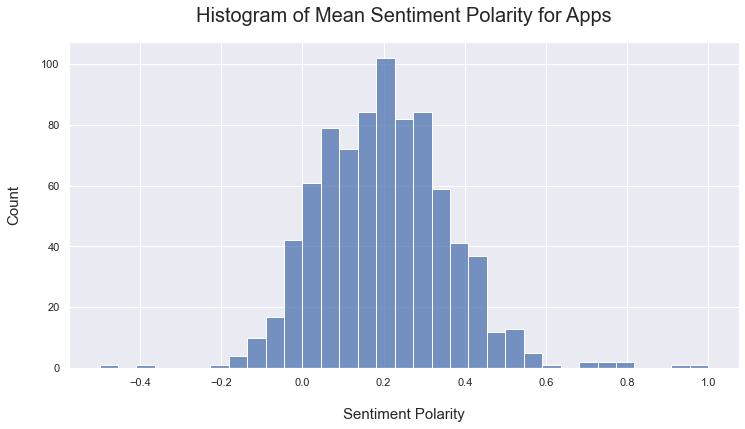

In [368]:
figure = plt.figure(figsize=(12, 6))
sns.histplot(apps['Polarity'])
plt.xlabel('Sentiment Polarity', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)
plt.title('Histogram of Mean Sentiment Polarity for Apps', fontsize=20, pad=20)
plt.show()

It appears that almost all apps have a positive average sentiment polarity. Not many have an average sentiment polarity below zero. 

Next, let's visualize a histogram of app ratings. 

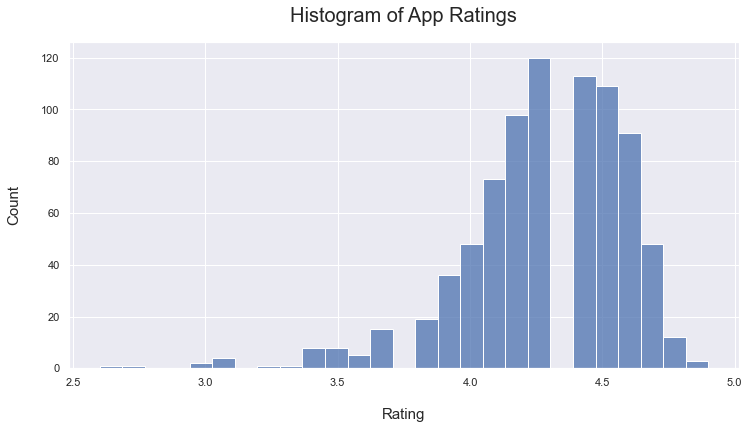

In [369]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()
sns.histplot(apps['Rating'])
plt.xlabel('Rating', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)
plt.title('Histogram of App Ratings', fontsize=20, pad=20)
plt.show()

So it adds up. It seems like the majority of apps are highly rated, which seems to go hand in hand with high positive sentiment polarities. 

Let's test to see if apps that generally have positive sentiment polarity reviews have different ratings than apps that generally have negative sentiment polarity reviews. 

In [370]:
positive_reviews = apps[apps['Sentiment'] == 'positive']
negative_reviews = apps[apps['Sentiment'] == 'negative']

Perform a Mann-Whitney U rank test on the rating of apps between the two groups. 

Null Hypothesis: Positive and negative sentiment polarities' underlying distributions are the same. 
    
Alternative Hypothesis: Positive and negative sentiment polarities' underlying distributions are not the same. The ratings for each group are different. 

In [371]:
stats.mannwhitneyu(positive_reviews['Rating'], negative_reviews['Rating']).pvalue

3.96547235695702e-09

With a pvalue of 3.96547235695702e-09, we strongly reject the null hypothesis and conclude that the app ratings are not the same for positive and negative sentiment polarities. 

Let's compute a correlation coefficient between sentiment polarity and app rating

In [372]:
# apps['log_polarity'] = np.log(apps['Polarity'])
# apps['log_rating'] = np.log(apps['Rating'])
# apps = apps[~apps['log_polarity'].isin([np.nan, 0])]
# apps = apps[~apps['log_rating'].isin([np.nan, 0])]
# stats.pearsonr(apps['log_polarity'], apps['log_rating'])

stats.pearsonr(apps['Polarity'], apps['Rating'])

(0.26405321132736725, 1.7496906302583513e-14)

With r = 0.265, they seem to be slightly linearly associated, although not by much. The tiny pvalue allows us to conclude that with 95% confidence, this is true correlation coefficient. 

Why is r so tiny? Let's analyze the scatter plot.

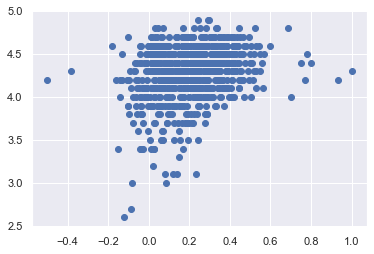

In [373]:
plt.scatter(apps['Polarity'], apps['Rating'])

Not many apps have a mean negative sentiment polarity. 


For some reason, the two apps with the lowest sentiment polarity have a rating of above 4. Let's explore why. 

In [392]:
lowest_polarity_app = apps.iloc[[apps['Polarity'].idxmin()]]

#From https://stackoverflow.com/questions/62219868/how-to-find-the-index-of-the-second-minimum-in-pandas-dataframe
second_lowest_polarity_app = apps.iloc[[apps['Polarity'].nsmallest(2).index[1]]]

app_reviews_lowest_polarity_app = app_reviews.merge(lowest_polarity_app, on='App', how='right')
app_reviews_second_lowest_polarity_app = app_reviews.merge(second_lowest_polarity_app, on='App', how='right')

In [405]:
# https://stackoverflow.com/questions/39680147/can-i-set-variable-column-widths-in-pandas
pd.set_option('max_colwidth', 400)
app_reviews_lowest_polarity_app[['Translated_Review']]

,Translated_Review
0,"From I read update, nothing value improvement app, added features functionality tuan selected group people. My point Google bloating useless features. It like giving person permission go movie, informing allowed watch it."
1,"Please keep updating the picture, because my house is in 2015. My cellphone is bad so the picture quality is bad. Makasi"
2,I hate
3,Can guys make possible places offline?


In [399]:

app_reviews.sort_values(by=['Polarity'], inplace=True)
app_reviews

,App,Translated_Review,Polarity
43381,Fake Call - Fake Caller ID,Worst it. Weast time. I'm getting tension.,-1.0
45608,FilterGrid - Cam&Photo Editor,I HATE THAT IT KEEPS SAYING TO RATE THEN! ITS ...,-1.0
5410,"AliExpress - Smarter Shopping, Better Living","Horrible service, horrible quality products on...",-1.0
49867,Freeletics: Personal Trainer & Fitness Workouts,Worst appp I seen till,-1.0
35209,Doctor Pets,awful,-1.0
...,...,...,...
41328,ExDialer - Dialer & Contacts,Best dialer I've found seems take things hands...,1.0
41310,ExDialer - Dialer & Contacts,THE BEST NON STOCK ANDROID DIALER INDEED. ***H...,1.0
41276,Evie Launcher,"Best launcher around, doubt it.",1.0
41935,EyeEm - Camera & Photo Filter,Awesome platform get photography seen photogra...,1.0
